In [6]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
from paper_sims_util import MCC, confusion
from running_wrappers import get_loaders
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
LOADERS = get_loaders()
AlgoParams = namedtuple('AlgoParams', 'stability_samples M pi')
GraphParams = namedtuple('GraphParams', 'N eta p d ratios')
import pandas as pd
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
run_name = 'DO_p_100_slashedp'
run_ids = range(20)
with open("{}_algo_params.pkl".format(run_name), 'rb') as f:
    algo_params = pickle.load(f)
with open("{}_graph_params_dict.pkl".format(run_name), 'rb') as f:
    graph_params_dict = pickle.load(f)
# graph_params_dict = {
#     'chain': GraphParams(p=20, N=[20, 25, 30, 35, 40], eta=1, ratios=None, d=None), #p, N, eta
#     'star': GraphParams(p=20, d=[10, 15, 20, 25, 30], N=50, eta=1, ratios=None), #p, d, N, eta
#     'random': GraphParams(p=20, d=0.01, ratios=[r/500. for r in [300, 375, 500, 750, 1000]], eta=1, N=None), #p, d, ratio over 500, eta
#     'grid_3D': GraphParams(p=2, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None), #p, ratio over 524, eta
#     'grid': GraphParams(p=7, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None) #p, ratio over 529, eta
# }

In [40]:
graph_params_dict = {'chain': GraphParams(N=[25, 50, 100, 200, 500, 1000], eta=1, p=100, d=None, ratios=None), 
                     'star': GraphParams(N=50, eta=1, p=100, d=[2,3, 4, 5], ratios=None), 
                     'random': GraphParams(N=None, eta=1, p=100, d=0.01, ratios=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0]), 
                     'grid': GraphParams(N=None, eta=1, p=10, d=None, ratios=[0.25, 0.5, 1.0, 2.0, 5.0, 10.0])}

In [39]:
def get_new_omega_hat(MTP2_precs):
    from final_algo import attr_threshold_new, get_stability_edges
    p = 100
    pi = 0.7
    lambdas = [0., 0.01, 0.05, 0.1, 0.2, 0.3]
    results = defaultdict(list)
    probs = {}
    edges = []
    for i in range(p):
        for j in range(i+1, p):
            edges.append((i,j))
    for q in lambdas:
        for prec in MTP2_precs:
            results[q].append(attr_threshold_new(prec, q))

        probs[q] = defaultdict(int)
        for res in results[q]:
            for e in edges:
                e_val = res[e]
                if e_val != 0:
                    probs[q][e] += 1
        for e in edges:
            probs[q][e] /= len(results[q])

    stable_edges = get_stability_edges(probs, lambdas, pi)
    omega = np.zeros((p,p))
    for e in stable_edges:
        omega[e] = 1
        omega[e[::-1]] = 1
    return omega

In [125]:
def get_points(loaded_data):
    points = defaultdict(lambda: defaultdict(list))
    print(loaded_data.keys())
    for x_label, trials in loaded_data.items(): #x_;
        print(x_label)
        for t_i, trial in enumerate(trials):
            if t_i > 5: #use 5 trials only
                continue
            print(t_i)
            #print(type(trial))
#             if type(trial) != dict:
#                 continue
            #print(x_label)
            #print(trials.keys())
            omega = trial[0]
            #print(np.sum(omega))
            results = trial[1]
            for algo_name, algo_results in results.items():
                if algo_name == 'SH':
                    omega_hat = get_new_omega_hat(algo_results[3])
                else:
                    omega_hat = algo_results[0]
                #print(algo_name, np.sum(omega_hat))
                #TP, TN, FP, FN = confusion(omega_hat, omega)
                #TPR = TP/(TP + FN)
                #FPR = FP/(FP + TN)
                algo_mcc = MCC(omega_hat, omega)
                #points[algo_name][x_label].append(TPR) #old algo_mcc
                points[algo_name][x_label].append(algo_mcc)
        print(points)
    return points

In [14]:
graph_params_dict = {
    'chain': GraphParams(p=100, N=[25, 50, 100, 200, 500, 1000], eta=1, ratios=None, d=None), #p, N, eta
    'star': GraphParams(p=100, d=[10, 20, 30, 50], N=50, eta=1, ratios=None), #p, d, N, eta
    'random': GraphParams(p=100, d=0.01, ratios=[r/100. for r in [25, 50, 100, 200, 500, 1000]], eta=1, N=None), #p, d, ratio over 500, eta
    #'grid_3D': GraphParams(p=4, ratios=new_grid_ratios, eta=2, N=None, d=None), #p, ratio over 524, eta
    'grid': GraphParams(p=10, ratios=[r/100. for r in [500,1000]], eta=1, N=None, d=None) #p, ratio over 529, eta
}
run_name = 'NIPS_rebuttal_clime'
run_ids = [0,1]
algo_params = AlgoParams(stability_samples=50, M=7./9., pi=0.8)
LOADED_DATA = LOADERS['random'](graph_params_dict['random'], 
                                  algo_params, 
                                  run_name,
                                  run_ids)

In [37]:
new_points = get_points(LOADED_DATA)

dict_keys([25, 50, 100, 200, 500, 1000])
25
0
defaultdict(<function get_points.<locals>.<lambda> at 0x1244f8f28>, {'our': defaultdict(<class 'list'>, {25: [0.2727272727272727]}), 'tiger': defaultdict(<class 'list'>, {25: [0.0]})})
50
0
defaultdict(<function get_points.<locals>.<lambda> at 0x1244f8f28>, {'our': defaultdict(<class 'list'>, {25: [0.2727272727272727], 50: [0.6829268292682927]}), 'tiger': defaultdict(<class 'list'>, {25: [0.0], 50: [0.4878048780487805]})})
100
0
defaultdict(<function get_points.<locals>.<lambda> at 0x1244f8f28>, {'our': defaultdict(<class 'list'>, {25: [0.2727272727272727], 50: [0.6829268292682927], 100: [0.6885245901639344]}), 'tiger': defaultdict(<class 'list'>, {25: [0.0], 50: [0.4878048780487805], 100: [0.9344262295081968]})})
200
0
defaultdict(<function get_points.<locals>.<lambda> at 0x1244f8f28>, {'our': defaultdict(<class 'list'>, {25: [0.2727272727272727], 50: [0.6829268292682927], 100: [0.6885245901639344], 200: [1.0]}), 'tiger': defaultdict(<clas

In [126]:
run_name = 'NIPS_rebuttal_ALL'
_points, rebuttal_lines = plot('random', ret=True)

Loaded data
dict_keys([25, 50, 100, 200, 500, 1000])
25
0
1
defaultdict(<function get_points.<locals>.<lambda> at 0x1253b71e0>, {'our': defaultdict(<class 'list'>, {25: [0.3247111758487925, 0.4616937218441082]}), 'tiger': defaultdict(<class 'list'>, {25: [0, 0]}), 'clime': defaultdict(<class 'list'>, {25: [0, 0]})})
50
0
1
defaultdict(<function get_points.<locals>.<lambda> at 0x1253b71e0>, {'our': defaultdict(<class 'list'>, {25: [0.3247111758487925, 0.4616937218441082], 50: [0.4629623016275518, 0.5352685946455787]}), 'tiger': defaultdict(<class 'list'>, {25: [0, 0], 50: [0, 0]}), 'clime': defaultdict(<class 'list'>, {25: [0, 0], 50: [0, 0]})})
100
0
1
defaultdict(<function get_points.<locals>.<lambda> at 0x1253b71e0>, {'our': defaultdict(<class 'list'>, {25: [0.3247111758487925, 0.4616937218441082], 50: [0.4629623016275518, 0.5352685946455787], 100: [0.9204418823932796, 0.886970163929273]}), 'tiger': defaultdict(<class 'list'>, {25: [0, 0], 50: [0, 0], 100: [0.5834148688386414, 0.3074

KeyboardInterrupt: 

In [68]:
rebuttal_lines

([25, 50, 100, 200, 500, 1000],
 defaultdict(list,
             {'our': [0.0025490259660623203,
               0.002549251946959586,
               0.0005091235740889699,
               0.00020395676116663266,
               0.0,
               0.0],
              'tiger': [0.0,
               0.0,
               0.0,
               0.001326343559959082,
               0.004492338372376916,
               0.012657485765213894],
              'clime': [0.0,
               0.0,
               0.0003054575525167977,
               0.0002041649652919559,
               0.00030631001124679306,
               0.0007141819948471231]}))

In [69]:
tiger_clime_chain_FPR_lines = {'our': [0.0035044320758606472,
               0.00041228612657184083,
               0.0,
               0.0,
               0.0,
               0.0],
              'tiger': [0.0,
               0.0,
               0.03566274994846423,
               0.06782106782106782,
               0.1090496804782519,
               0.15089672232529375],
              'clime': [0.009894867037724181,
               0.020202020202020204,
               0.016903731189445475,
               0.017109874252731395,
               0.036281179138321996,
               0.01834673263244692]}
tiger_clime_random_FPR_lines = {'our': [0.0025490259660623203,
               0.002549251946959586,
               0.0005091235740889699,
               0.00020395676116663266,
               0.0,
               0.0],
              'tiger': [0.0,
               0.0,
               0.0,
               0.001326343559959082,
               0.004492338372376916,
               0.012657485765213894],
              'clime': [0.0,
               0.0,
               0.0003054575525167977,
               0.0002041649652919559,
               0.00030631001124679306,
               0.0007141819948471231]}

In [22]:
tiger_clime_chain_new_lines = {'our': [0.5050505050505051,
               0.898989898989899,
               1.0,
               1.0,
               1.0,
               1.0],
              'tiger': [0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
              'clime': [0.0,
               0.29292929292929293,
               0.7575757575757576,
               0.98989898989899,
               1.0,
               1.0]}

In [19]:
tiger_clime_random_new_lines = {'our': [0.30514705882352944,
               0.41428571428571426,
               0.8771929824561404,
               0.9478314238952537,
               1.0,
               1.0],
              'tiger': [0.0,
               0.0,
               0.218671679197995,
               0.48097381342062195,
               1.0,
               1.0],
              'clime': [0.0,
               0.0,
               0.3101503759398496,
               0.7092880523731588,
               1.0,
               1.0]}

In [23]:
def plot_lines(d):
    lines = defaultdict(list)
    x_labels = list(next(iter(d.values())).keys())
    for algo_name, x_label_to_trials in d.items():
        for x_label in x_labels:
            trial_MCCs = x_label_to_trials[x_label]
            lines[algo_name].append(np.mean(trial_MCCs))
    return x_labels, lines

In [24]:
def plot(graph_type, ret = False):
    loaded_data = LOADERS[graph_type](graph_params_dict[graph_type], 
                                  algo_params, 
                                  run_name,
                                  run_ids)
    print('Loaded data')
    points = get_points(loaded_data)
    lines = plot_lines(points)
    if ret:
        return points, lines
    for algo, line in lines[1].items():
        plt.plot(lines[0], line, label=algo)
    plt.title(graph_type)
    plt.legend()
    plt.show()

In [134]:
graph_type = 'chain'
run_name = 'pickle/DO_p_100_slashedp'
points, lines = plot(graph_type, True)

pickle/DO_p_100_slashedp_0_chain_25_results.pkl
pickle/DO_p_100_slashedp_1_chain_25_results.pkl
pickle/DO_p_100_slashedp_0_chain_50_results.pkl
pickle/DO_p_100_slashedp_1_chain_50_results.pkl
pickle/DO_p_100_slashedp_0_chain_100_results.pkl
pickle/DO_p_100_slashedp_1_chain_100_results.pkl
pickle/DO_p_100_slashedp_0_chain_200_results.pkl
pickle/DO_p_100_slashedp_1_chain_200_results.pkl
pickle/DO_p_100_slashedp_0_chain_500_results.pkl
pickle/DO_p_100_slashedp_1_chain_500_results.pkl
pickle/DO_p_100_slashedp_0_chain_1000_results.pkl
pickle/DO_p_100_slashedp_1_chain_1000_results.pkl
Loaded data
dict_keys([25, 50, 100, 200, 500, 1000])
25
0
1
defaultdict(<function get_points.<locals>.<lambda> at 0x122357bf8>, {'our': defaultdict(<class 'list'>, {25: [0.6326396192899735, 0.6409328383190851]}), 'SH': defaultdict(<class 'list'>, {25: [0.5821455224218718, 0.555700100913172]}), 'glasso': defaultdict(<class 'list'>, {25: [0, 0.29707728071663064]}), 'nbsel': defaultdict(<class 'list'>, {25: [0.811

In [117]:
lines

([25, 50, 100, 200, 500, 1000],
 defaultdict(list,
             {'our': [0.2506127450980392,
               0.35792682926829267,
               0.5333333333333333,
               0.6209947393591583,
               0.7608213096559377,
               0.7354651162790697],
              'SH': [0.0,
               0.012195121951219513,
               0.0,
               0.0,
               0.0196078431372549,
               0.0],
              'glasso': [0.0,
               0.25945121951219513,
               0.35679824561403506,
               0.7187948350071736,
               0.7989271180170181,
               0.8284883720930232],
              'nbsel': [0.22120098039215685,
               0.48109756097560974,
               0.737280701754386,
               0.7604017216642754,
               0.9038105808361081,
               0.8835271317829457],
              'anand': [0.4920343137254902,
               0.6039634146341464,
               0.8173245614035087,
               0.78000956480

### Generate Plot

In [27]:
tiger_clime_random_new_lines

{'our': [0.30514705882352944,
  0.41428571428571426,
  0.8771929824561404,
  0.9478314238952537,
  1.0,
  1.0],
 'tiger': [0.0, 0.0, 0.218671679197995, 0.48097381342062195, 1.0, 1.0],
 'clime': [0.0, 0.0, 0.3101503759398496, 0.7092880523731588, 1.0, 1.0]}

In [135]:
tiger_clime_dict = tiger_clime_chain_new_lines
lines[1]['tiger'] = tiger_clime_dict['tiger']
lines[1]['clime'] = tiger_clime_dict['clime']
if 'our' in tiger_clime_dict:
    lines[1]['our'] = tiger_clime_dict['our']

In [2]:
import pandas as pd
d = {("our", 1, 0.5): 0.5}
pd.DataFrame(d)

ValueError: If using all scalar values, you must pass an index

In [136]:
tups = []
for algo_name in lines[1].keys():
    for t in zip(lines[0], lines[1][algo_name]):
        tups.append((algo_name,) + t)

In [137]:
df = pd.DataFrame(tups, columns = ['Algorithm', 'N', 'MCC'])

In [138]:
df

,Algorithm,N,MCC
0,our,25,0.505051
1,our,50,0.898990
2,our,100,1.000000
3,our,200,1.000000
4,our,500,1.000000
5,our,1000,1.000000
6,SH,25,0.568923
7,SH,50,0.714216
8,SH,100,0.677799
9,SH,200,0.717737


Manually set graph type


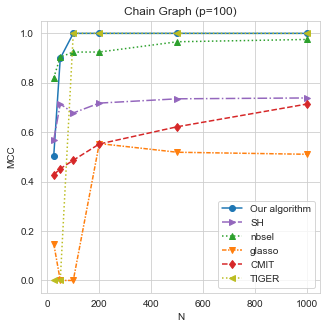

In [140]:
groupby = df.groupby('Algorithm')
labels = {'our': 'Our algorithm', 
          'SH_best': 'SH (best q)', 
          'SH_0.7': 'SH (no stability selection)',
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$',
          'tiger': 'TIGER',
          'clime': 'CLIME'}
markers = {'our': 'o', 
           'SH_best': '<', 
           'SH_0.7': '<', 
           'SH': '>', 
           'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*', 
          'tiger': '<', 'clime': '*'}
linestyles = {'our': 'solid', 
              'SH_best': 'dashdot', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid', 
              'tiger': 'dotted', 
              'clime': 'solid'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_best': 'C6',
    'SH_0.7': 'C6',
    'our_85': 'C9',
    'tiger': 'C8',
    'clime': 'C7'
}
sns.set_style("whitegrid")
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))
#ax.set_yticks(np.linspace(0, 0.15, 6))
#plt.xlim((0,1000))
all_graphs = ['our', 'our_85', 'SH', 'SH_0.7', 'nbsel', 'glasso', 'anand']
main_graphs = ['our', 'SH', 'nbsel', 'glasso', 'anand', 'tiger'] #'clime'] #'SH_best' used to be in here
relevant_graphs = ['our', 'our_85', 'SH', 'SH_0.7']
#rebuttal_graphs = ['our', 'tiger', 'clime']
use_graphs = main_graphs
for algo_name in use_graphs:
    item = groupby.get_group(algo_name)
    plt.plot(item.N, item.MCC, 
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name])

plt.legend(loc='lower right')
graph_type = 'Chain Graph (p=100)'
print("Manually set graph type")
plt.title(graph_type)
plt.xlabel("N")
plt.ylabel("MCC")
plt.show()
save_path = '/{}_no_stab.png'
# if input("save to {}".format(save_path)) == 'Y':
#     fig.savefig((save_path).format(graph_type))

In [61]:
print("hi")

hi
